# Time-Series Anomaly Detection

**Goal:** Detect anomalies in time-series data. Example use cases: equipment failures in sensor data, or sudden traffic spikes.

I will do this in two different ways:

1) Unsupervised
    - Dropping the label column

2) Supervised
    - Using the full data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

### Loading and visualizing the data

In [2]:
df = pd.read_csv("./data/synthetic_time_series_anomaly_dataset.csv")

#### Data Preprocessing

Extracting difference and slope features. It works better for gradially changing anomalies

In [3]:
df["temp_diff"] = df["temperature"].diff().fillna(0)
df["temp_slope"] = df["temperature"].rolling(20).mean().diff().fillna(0).clip(lower=0)

print(df.head())
print(df.label.value_counts())

             timestamp  temperature  vibration    pressure          rpm  \
0  2025-01-01 00:00:00    69.585021   0.039131  101.822671  2450.245503   
1  2025-01-01 00:00:01    70.167931   0.029449  101.333643  2460.002396   
2  2025-01-01 00:00:02    69.973833   0.026363  100.940321  2451.305008   
3  2025-01-01 00:00:03    69.940313   0.028197  101.279200  2441.587510   
4  2025-01-01 00:00:04    70.253221   0.037199  101.424955  2452.681664   

    label  temp_diff  temp_slope  
0  normal   0.000000         0.0  
1  normal   0.582911         0.0  
2  normal  -0.194099         0.0  
3  normal  -0.033520         0.0  
4  normal   0.312908         0.0  
label
normal    229249
overhe     70049
pressu       400
vibrat       302
Name: count, dtype: int64


In [4]:
features = ["temperature", "vibration", "pressure", "rpm", "temp_diff", "temp_slope"]

X = df[features].values
y = df["label"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
normal_df = df[df.label == "normal"]
X_normal = scaler.transform(normal_df[features])

# Create sequences for LSTM
def create_sequences(data, length=30):
    xs = []
    for i in range(len(data) - length):
        xs.append(data[i:i+length])
    return np.array(xs)

seq_len = 15
X_seq = create_sequences(X_normal, seq_len)

X_seq.shape

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


(229234, 15, 6)

In [6]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"

class LSTMAE(nn.Module):
    def __init__(self, n_features, hidden=32):
        super().__init__()
        self.encoder = nn.LSTM(n_features, hidden, batch_first=True)
        self.decoder = nn.LSTM(hidden, n_features, batch_first=True)

    def forward(self, x):
        z, _ = self.encoder(x)
        z_last = z[:, -1, :].unsqueeze(1).repeat(1, x.size(1), 1)
        recon, _ = self.decoder(z_last)
        return recon

model = LSTMAE(n_features=6).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)

model.train()
for epoch in range(20):
    optimizer.zero_grad()
    recon = model(X_tensor)
    loss = criterion(recon, X_tensor)
    loss.backward()
    optimizer.step()
    print("epoch:", epoch, "loss:", loss.item())


epoch: 0 loss: 0.6303672194480896
epoch: 1 loss: 0.6273790001869202
epoch: 2 loss: 0.624567985534668
epoch: 3 loss: 0.6219265460968018
epoch: 4 loss: 0.6194465160369873
epoch: 5 loss: 0.6171183586120605
epoch: 6 loss: 0.614932119846344
epoch: 7 loss: 0.6128771901130676
epoch: 8 loss: 0.6109433770179749
epoch: 9 loss: 0.609120786190033
epoch: 10 loss: 0.6073993444442749
epoch: 11 loss: 0.6057693958282471
epoch: 12 loss: 0.6042218208312988
epoch: 13 loss: 0.6027476787567139
epoch: 14 loss: 0.6013383865356445
epoch: 15 loss: 0.5999858379364014
epoch: 16 loss: 0.598682701587677
epoch: 17 loss: 0.5974221229553223
epoch: 18 loss: 0.596197783946991
epoch: 19 loss: 0.5950038433074951


In [7]:
# Build sequences over full dataset
X_full = scaler.transform(df[features])
X_full_seq = create_sequences(X_full, seq_len)

X_full_tensor = torch.tensor(X_full_seq, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    recon_full = model(X_full_tensor)

errors = torch.mean((X_full_tensor - recon_full)**2, dim=(1,2)).cpu().numpy()

# Pad to match dataset length
full_errors_padded = np.concatenate([np.zeros(seq_len), errors])
df["ae_error"] = full_errors_padded


C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [22]:
threshold = df["ae_error"].mean() + 0.1 * df["ae_error"].std()
df["ae_anomaly"] = (df["ae_error"] > threshold).astype(int)

df["ae_anomaly"].value_counts()


ae_anomaly
0    259835
1     40165
Name: count, dtype: int64

Visualizing:

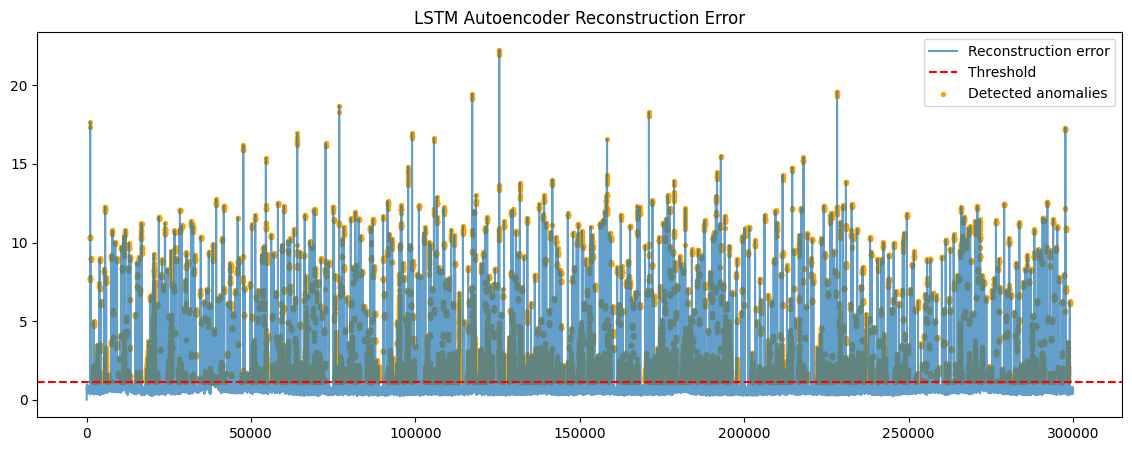

In [45]:
plt.figure(figsize=(14,5))
plt.plot(df["ae_error"], label="Reconstruction error", alpha=0.7)

threshold = df["ae_error"].mean() + 0.1 * df["ae_error"].std()
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

# Mark anomalies
anomaly_idx = df[df["ae_anomaly"] == 1].index
plt.scatter(anomaly_idx, df.loc[anomaly_idx, "ae_error"],
            color="orange", label="Detected anomalies", s=8)

plt.title("LSTM Autoencoder Reconstruction Error")
plt.legend()
plt.show()

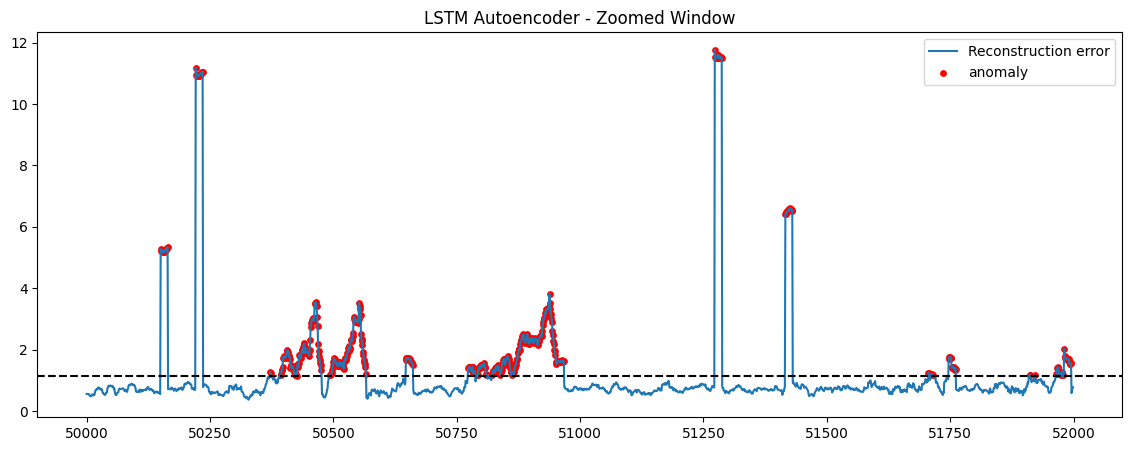

In [46]:
start = 50_000
end = 52_000

window = df.iloc[start:end]

plt.figure(figsize=(14,5))
plt.plot(window["ae_error"], label="Reconstruction error")

# anomalies
anoms = window[window["ae_anomaly"] == 1]
plt.scatter(anoms.index, 
            anoms["ae_error"], 
            color="red", label="anomaly", s=15)

plt.axhline(threshold, linestyle="--", color="black")
plt.title("LSTM Autoencoder - Zoomed Window")
plt.legend()
plt.show()

Plotting some features side by side so we can visually see that it works:

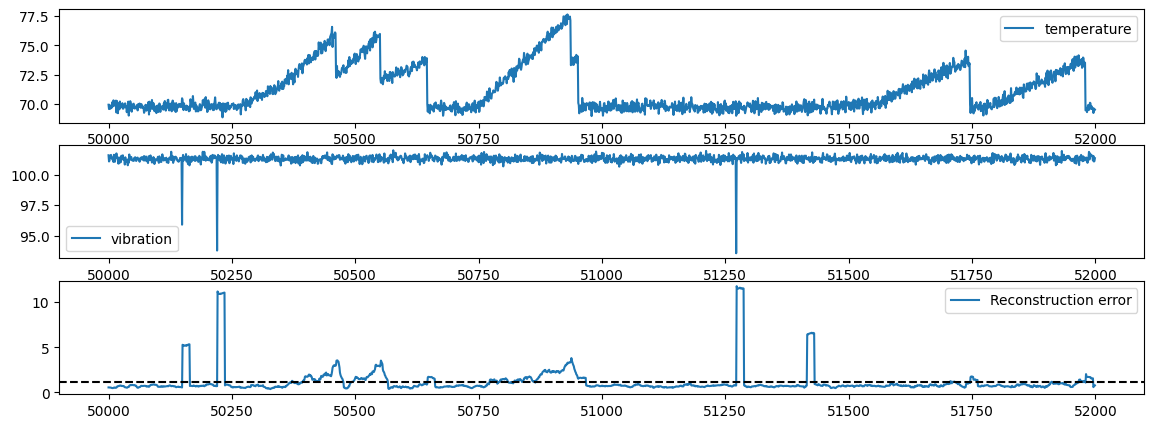

In [47]:
plt.figure(figsize=(14,5))
plt.subplot(3, 1, 1)
plt.plot(window["temperature"], label="temperature")
plt.legend()    
plt.subplot(3, 1, 2)
plt.plot(window["pressure"], label="vibration")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(window["ae_error"], label="Reconstruction error")
plt.axhline(threshold, linestyle="--", color="black")
plt.legend()
plt.show()

## 2) XGB

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [10]:
from xgboost import XGBClassifier

clf = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8
)

clf.fit(X_train, y_train)

print("Train acc:", clf.score(X_train, y_train))
print("Test acc:", clf.score(X_test, y_test))


Train acc: 0.9007375
Test acc: 0.89265


In [11]:
preds = clf.predict(X_test)
df_results = pd.DataFrame({
    "true": le.inverse_transform(y_test),
    "pred": le.inverse_transform(preds)
})

df_results.head(20)


,true,pred
0,normal,normal
1,overhe,overhe
2,normal,normal
3,normal,normal
4,normal,normal
5,normal,normal
6,overhe,normal
7,normal,normal
8,normal,normal
9,normal,normal


Visuals:

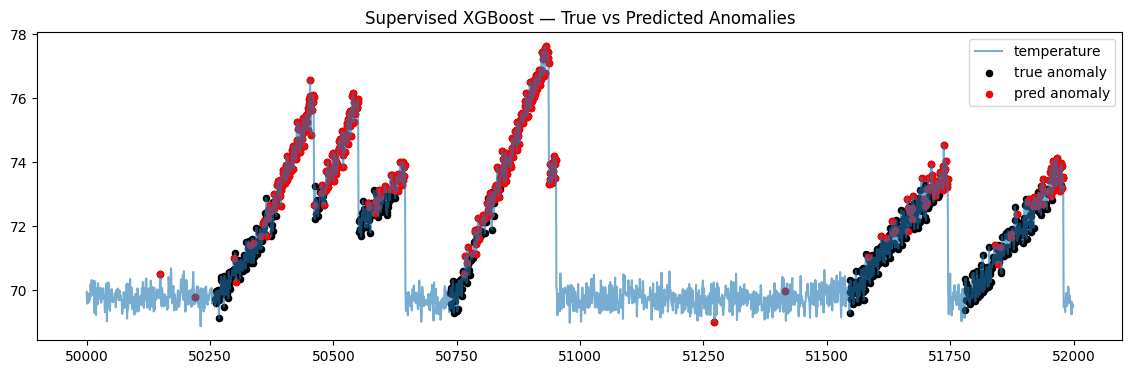

In [48]:
# Add predictions back into df once clf is trained
df["xgb_pred"] = clf.predict(X_scaled)

# Convert encoded labels back to strings
df["true_str"] = df["label"]
df["pred_str"] = le.inverse_transform(df["xgb_pred"])

# plot a small time window
start = 50_000
end = 52_000
window = df.iloc[start:end]

plt.figure(figsize=(14,4))

plt.plot(window["temperature"], label="temperature", alpha=0.6)

# true anomalies
true_anoms = window[window["true_str"] != "normal"]
plt.scatter(true_anoms.index, 
            true_anoms["temperature"],
            color="black", label="true anomaly", s=20)

# predicted anomalies
pred_anoms = window[window["pred_str"] != "normal"]
plt.scatter(pred_anoms.index,
            pred_anoms["temperature"],
            color="red", label="pred anomaly", s=20)

plt.title("Supervised XGBoost — True vs Predicted Anomalies")
plt.legend()
plt.show()


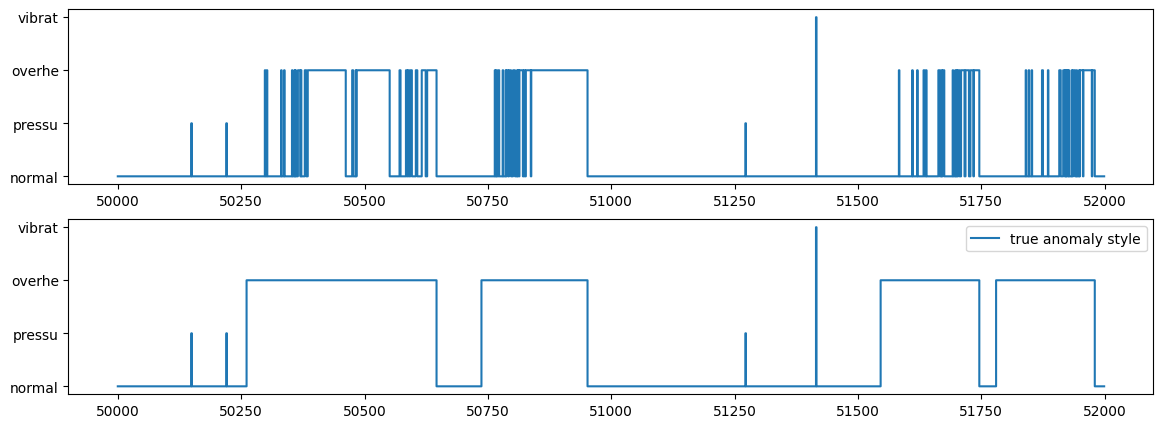

In [49]:
plt.figure(figsize=(14,5))
plt.subplot(2, 1, 1)
plt.plot(window["pred_str"], label="predicted anomaly style", drawstyle="steps-post")
plt.subplot(2, 1, 2)
plt.plot(window["true_str"], label="true anomaly style", drawstyle="steps-post")
plt.legend()
plt.show()